### bibliotecas

In [430]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

---
$$
\hat y = F\,y + G\,\Delta u
$$
---

In [431]:
def get_F(H, N):
    # get len of denominator (number of poles)
    len_poles = H.den[0][0].shape[0] - 1

    # C = [1, 0, ..., 0] (len_poles zeros)
    C = np.zeros(len_poles)
    C[0] = 1

    # eye - the last line will be removed
    I = np.eye(len_poles)[:len_poles-1]

    # a = poles[:] ao contrario
    a_arr = -np.array(H.den[0][0][:])[::]
    a_arr = a_arr[1:]  # remove a0

    # A = [[poles], [I]]
    A = np.zeros((len_poles, len_poles))
    A[0, :] = a_arr
    A[1:, :] = I

    # F = N x len_poles
    F = np.zeros((N, len_poles))
    for i in range(N):
        F[i, :] = C @ np.linalg.matrix_power(A, i+1)

    return F

def get_M_and_g(H, N):
    # get len of numerator (number of zeros)
    len_zeros = H.num[0][0].shape[0]

    # M = N x len_zeros
    M = np.zeros((N, len_zeros))

    # the first row is just the numerator coefficients
    M[0, :] = np.array(H.num[0][0][:])

    # a = poles[:] ao contrario
    a_arr = -np.array(H.den[0][0][:])[::]
    a_arr = a_arr[1:]  # remove a0

    # fill the rest of M
    for i in range(1, N):
        for j in range(len_zeros):
            for k in range(0, i):   
                hij = M[i-k -1, j] #if i - k > 0 else 0
                a = a_arr[k] if k < len(a_arr) else 0
                M[i, j] += a * hij

            last = M[0, i + j] if i + j < len_zeros else 0
            M[i, j] += last

    # g = first column of M
    g = M[:, 0]

    # M without last column
    #M = M[:, :-1]

    return g

def get_G(g, N_u, N):
    # G = N x N_u
    G = np.zeros((N, N_u))

    for i in range(N):
        for j in range(N_u):
            if i - j >= 0:
                G[i, j] = g[i - j]

    return G

# generate all matrices
def generate_matrices(H, N_u, N):
    F = get_F(H, N)
    g = get_M_and_g(H, N)
    G = get_G(g, N_u, N)

    return F, G

---
Modelo

---

In [432]:
# sample
Ts = 1

# discrete transfer function coefficients
a2, a1, a0 = 0.9, -0.5, 1
b2, b1, b0 = 0.3, 0.5, 0.1
c1, c0 = 0.1, 0

# polynomials A(z) and B(z)
A = [a0, a1, a2]
B = [b0, b1, a2]
C = [c0, c1]

# transfer function H = Y/U = B/A z^-1
delta = ctrl.TransferFunction([Ts, 0], [1, -1], Ts, )
H_u = ctrl.TransferFunction(B, A, Ts)
H_u = H_u * delta

# transfer function H = Y/Q = C/A z^-1
H_q = ctrl.TransferFunction(C, A, Ts)
H_q = H_q * delta

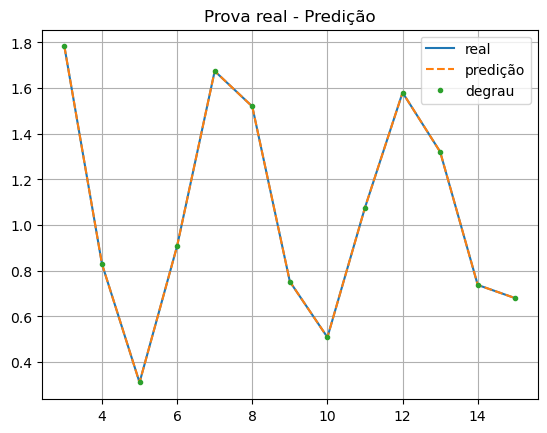

In [433]:
F, G = generate_matrices(H_u, N_u=3, N=16)
time, y1 = H_u.impulse_response(T=15)

y1_reverse = y1[:3]
y1_reverse = y1_reverse[::-1]
y2 = F @ y1_reverse[:3].T

delta_u = [1, 0, 0]
y3 = G @ delta_u

# plot 
plt.plot(time[3:], y1[3:], label="real")
plt.plot(time[3:], y2[:13], '--', label="predição")
plt.plot(time[3:], y3[3:], '.', label="degrau")
plt.title("Prova real - Predição")
plt.legend()
plt.grid()
plt.show()